In [1]:
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from pyomo.environ import ConcreteModel, SolverFactory, TerminationCondition, \
    value, Var, Constraint, Expression, Objective, TransformationFactory, units as pyunits
from pyomo.network import Arc, SequentialDecomposition
from idaes.core.util.model_statistics import degrees_of_freedom

from split_test2 import Separator1

from mixer_example import Mixer1

### TODO: CREATE INTRO

##### Import WaterTAP3 Package

In [2]:
import watertap as wt

##### Step 1: Look up unit process library. Returns a List.

##### Step 3: Set up IDAES flowsheet for watertap. This selects a property package for you (see water_props.py). The property package could be changed in the future for performing heat/energy and other balances.

In [3]:
m = wt.watertap_setup(dynamic = False)

##### Step 3: Add a water source and define inlet flow.

In [4]:
m = wt.case_study_trains.get_case_study(name = 'carlsbad', flow = 4.5833, m = m)

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

In [5]:
wt.display.show_train2(model_name=m)

In [6]:
##### Step 5:  Run model and display results. The resutls display will be put into easier format to read for user soon.

In [7]:
result = wt.run_water_tap(m)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

In [49]:
unit_process_names = [
    "swoi", 
    "coag_floc",
    "tri_media_filtration",
    "SAA",
    "SBA",
    "cf",
    "ro",
    "lime",
    "co2",
    "chlor",
    "ammonia",
    "TWS_24_hr",
    "muni"
]


cost_variables = [
    "total_up_cost",
    "fixed_cap_inv_unadjusted",
    "fixed_cap_inv",
    "total_fixed_op_cost",
    "total_cap_investment",
    "land_cost",
    "working_cap",
    "catalysts_chemicals",#
    #"electricity",##
    "cap_replacement_parts", #
    "salaries",
    "benefits",
    "maintenance",
    "lab",
    "insurance_taxes",
    "base_employee_salary_cost",
    
    "cat_and_chem_cost",##
    "labor_and_other_fixed",#
    "consumer_price_index",#
    
    "electricity_cost", ##
    "other_var_cost"   ## 
]

In [50]:
def get_results_table(model, unit_process_names):
    data = {} 

    for variable in cost_variables:
        cost_list = []
        for node in unit_process_names:
            # call m.fs.'node'.costing.'variable'() for each node and variable
            costing_attr = getattr(m.fs, node).costing
            cost_method = getattr(costing_attr, variable) #m.fs.swoi.costing.total_up_cost
            
            #Todo: add unit (e.g. million $ or m3/s etc.)
            
            if type(cost_method) == int:
                cost_method = np.float64(cost_method)
                
            if type(cost_method) == np.float64:
                cost_value = cost_method
            else:
                cost_value = cost_method()
            # append ^ to a list
            cost_list.append(cost_value)            
            
        # assign 'variable': List['node' values] in a data dictionary
        data[variable] = cost_list
    
    
    df = pd.DataFrame(data = data, index = unit_process_names, columns = cost_variables)
    
    
    
    #print(df)
    return df
    

In [51]:
get_results_table(m, unit_process_names).to_csv("excel_comparison.csv")

In [52]:
get_results_table(m, unit_process_names).head()

,total_up_cost,fixed_cap_inv_unadjusted,fixed_cap_inv,total_fixed_op_cost,total_cap_investment,land_cost,working_cap,catalysts_chemicals,cap_replacement_parts,salaries,benefits,maintenance,lab,insurance_taxes,base_employee_salary_cost,cat_and_chem_cost,labor_and_other_fixed,consumer_price_index,electricity_cost,other_var_cost
swoi,23.366026,20.308784,20.980305,1.305235,22.060791,0.031470,1.049015,1.045314,1.033066,0.543417,0.489075,0.167842,0.062941,0.041961,0.020309,0.000000,1.032158,1.034582,1.984638,-1.984638
coag_floc,14.211373,11.765810,11.765810,0.732488,12.371749,0.017649,0.588291,1.000000,1.000000,0.305017,0.274515,0.094126,0.035297,0.023532,0.011766,1.008727,1.000000,1.000000,0.098409,0.000000
tri_media_filtration,42.354232,11.748013,12.751178,24.703293,13.407863,0.019127,0.637559,1.094885,1.085390,12.914488,11.623039,0.102009,0.038254,0.025502,0.011748,0.000000,1.144289,1.104141,4.243076,0.000000
SAA,0.716879,0.351380,0.418187,0.027077,0.439723,0.000627,0.020909,1.449793,1.190128,0.011390,0.010251,0.003345,0.001255,0.000836,0.000351,0.250068,1.255215,1.260734,0.000011,0.000000
SBA,1.217590,0.351816,0.418706,0.027110,0.440270,0.000628,0.020935,1.449793,1.190128,0.011404,0.010263,0.003350,0.001256,0.000837,0.000352,0.750197,1.255215,1.260734,0.000013,0.000000


In [10]:
variables = cost_variables + ["inlet_flow", "outlet_flow", "waste_flow"]

In [11]:
def get_results_table(model, unit_process_names, scenario = None, case_study = None):
    # could make a dictionary if betteR?
    value_list = [] 
    up_list = []
    scenario_list = []
    unit_list = []
    variable_list = []
    case_study_list = []
    
    for node in unit_process_names:
        
        for variable in variables:
            
            if variable == "inlet_flow":
                value_list.append(getattr(m.fs, node).inlet.flow_vol.extract_values()[0])
                variable_list.append(variable)
                unit_list.append("m3/s")
            elif variable == "outlet_flow":
                value_list.append(getattr(m.fs, node).outlet.flow_vol.extract_values()[0])
                variable_list.append(variable)
                unit_list.append("m3/s")
            elif variable == "waste_flow":
                value_list.append(getattr(m.fs, node).waste.flow_vol.extract_values()[0])
                variable_list.append(variable)
                unit_list.append("m3/s")
            else:
                # call m.fs.'node'.costing.'variable'() for each node and variable
                costing_attr = getattr(m.fs, node).costing
                cost_method = getattr(costing_attr, variable) #m.fs.swoi.costing.total_up_cost            
            
                if type(cost_method) == int:
                    cost_method = np.float64(cost_method)

                if type(cost_method) == np.float64:
                    cost_value = cost_method
                else:
                    cost_value = cost_method()
                # append ^ to a list
                value_list.append(cost_value)            
                variable_list.append(variable)
                unit_list.append("$MM")        
        
            up_list.append(node)
            scenario_list.append(scenario)
            case_study_list.append(case_study)
    
    df = pd.DataFrame()
    df["Case_Study"] = case_study_list
    df["Scenario"] = scenario_list
    df["Unit_Process"] = up_list
    df["Variable"] = variable_list
    df["Unit"] = unit_list
    df["Value"] = value_list
    
    #print(df)
    return df

In [12]:
t1 = get_results_table(m, unit_process_names, scenario = "Baseline", case_study = "Carlsbad")

In [13]:
t1.head()

,Case_Study,Scenario,Unit_Process,Variable,Unit,Value
0,Carlsbad,Baseline,swoi,total_up_cost,$MM,23.366026
1,Carlsbad,Baseline,swoi,fixed_cap_inv_unadjusted,$MM,20.308784
2,Carlsbad,Baseline,swoi,fixed_cap_inv,$MM,20.980305
3,Carlsbad,Baseline,swoi,total_fixed_op_cost,$MM,1.305235
4,Carlsbad,Baseline,swoi,total_cap_investment,$MM,22.060791


In [14]:
t1.to_csv("results_v2.csv")

In [15]:
m.fs.tri_media_filtration.inlet.flow_vol.extract_values()[0]

5.064327456187778

In [16]:
m.fs.tri_media_filtration.costing.salaries()

12.914488212339975

In [17]:
m.fs.chlor.costing.catalysts_chemicals

1.0948846182937026

In [18]:
m.fs.chlor.costing.applied_cl2_dose * 3.78541178 * (0.34) * 1.0948846182937026 * 365 * 2.399478 * 22.824465227271


267605.01864422136

In [31]:
t1[t1.Unit_Process == "swoi"]

,Case_Study,Scenario,Unit_Process,Variable,Unit,Value
0,Carlsbad,Baseline,swoi,total_up_cost,$MM,23.366026
1,Carlsbad,Baseline,swoi,fixed_cap_inv_unadjusted,$MM,20.308784
2,Carlsbad,Baseline,swoi,fixed_cap_inv,$MM,20.980305
3,Carlsbad,Baseline,swoi,total_fixed_op_cost,$MM,1.305235
4,Carlsbad,Baseline,swoi,total_cap_investment,$MM,22.060791
5,Carlsbad,Baseline,swoi,land_cost,$MM,0.031470
6,Carlsbad,Baseline,swoi,working_cap,$MM,1.049015
7,Carlsbad,Baseline,swoi,catalysts_chemicals,$MM,1.045314
8,Carlsbad,Baseline,swoi,cap_replacement_parts,$MM,1.033066
9,Carlsbad,Baseline,swoi,salaries,$MM,0.543417


In [48]:
results_table = get_results_table(m, unit_process_name)

In [49]:
results_table.total_up_cost.sum()

462.8602092987865

In [50]:
results_table

,total_up_cost,fixed_cap_inv_unadjusted,fixed_cap_inv,total_fixed_op_cost,total_cap_investment,land_cost,working_cap,catalysts_chemicals,cap_replacement_parts,salaries,benefits,maintenance,lab,insurance_taxes,base_employee_salary_cost,cat_and_chem_cost,labor_and_other_fixed,consumer_price_index,electricity_cost,other_var_cost
swoi,23.366026,20.308784,20.980305,1.305235,22.060791,0.031470,1.049015,1.045314,1.033066,0.543417,0.489075,0.167842,0.062941,0.041961,0.020309,0.000000,1.032158,1.034582,1.984638,-1.984638
coag_floc,15.121692,11.765810,11.765810,0.732488,12.371749,0.017649,0.588291,1.000000,1.000000,0.305017,0.274515,0.094126,0.035297,0.023532,0.011766,1.008727,1.000000,1.000000,0.098409,0.910319
tri_media_filtration,14.283696,11.748013,12.751178,0.875833,13.407863,0.019127,0.637559,1.094885,1.085390,0.373720,0.336348,0.102009,0.038254,0.025502,0.011748,0.000000,1.144289,1.104141,4.243076,-4.243076
SAA,0.966936,0.351380,0.418187,0.027077,0.439723,0.000627,0.020909,1.449793,1.190128,0.011390,0.010251,0.003345,0.001255,0.000836,0.000351,0.250068,1.255215,1.260734,0.000011,0.250057
SBA,1.967774,0.351816,0.418706,0.027110,0.440270,0.000628,0.020935,1.449793,1.190128,0.011404,0.010263,0.003350,0.001256,0.000837,0.000352,0.750197,1.255215,1.260734,0.000013,0.750183
cf,13.380566,11.044252,11.987322,0.775897,12.604669,0.017981,0.599366,1.094885,1.085390,0.326348,0.293714,0.095899,0.035962,0.023975,0.011044,0.000000,1.144289,1.104141,0.000000,-0.000000
ro,296.404263,223.115886,265.536470,17.192665,279.211598,0.398305,13.276824,1.449793,1.190128,7.231943,6.508748,2.124292,0.796609,0.531073,0.223116,0.000000,1.255215,1.260734,33.747012,-33.747012
lime,59.544991,52.909213,52.909213,2.344555,55.634037,0.079364,2.645461,1.000000,1.000000,0.871966,0.784769,0.423274,0.158728,0.105818,0.052909,0.783200,1.000000,1.000000,0.101469,0.681730
co2,8.515704,7.646860,7.771228,0.344258,8.171446,0.011657,0.388561,1.022155,1.016264,0.128017,0.115215,0.062170,0.023314,0.015542,0.007647,0.000000,1.015824,1.016997,0.101468,-0.101468
chlor,10.362694,8.699168,9.441991,0.434440,9.928254,0.014163,0.472100,1.094885,1.085390,0.164050,0.147645,0.075536,0.028326,0.018884,0.008699,0.000000,1.144289,1.104141,0.101467,-0.101467


In [51]:
#results_table = pd.read_csv('./cost_results.csv',index_col=0)
results_table.index.names=['Unit_Process']
results_table = results_table.reset_index()
df = pd.melt(results_table, id_vars=['Unit_Process'], value_vars=results_table.columns.to_list()[1:])

In [52]:
df["Case_Study"] = "Carlsbad"
df["Unit"] = "Million $"
df["Scenario"] = "A"


In [53]:
df

,Unit_Process,variable,value,Case_Study,Unit
0,swoi,total_up_cost,23.366026,Carlsbad,Million $
1,coag_floc,total_up_cost,15.121692,Carlsbad,Million $
2,tri_media_filtration,total_up_cost,14.283696,Carlsbad,Million $
3,SAA,total_up_cost,0.966936,Carlsbad,Million $
4,SBA,total_up_cost,1.967774,Carlsbad,Million $
...,...,...,...,...,...
255,co2,other_var_cost,-0.101468,Carlsbad,Million $
256,chlor,other_var_cost,-0.101467,Carlsbad,Million $
257,ammonia,other_var_cost,-0.000012,Carlsbad,Million $
258,TWS_24_hr,other_var_cost,-0.000000,Carlsbad,Million $


In [60]:
m.fs.tri_media_filtration.inlet.flow_vol.display()

flow_vol_in : Volumetric flowrate of water into unit
    Size=1, Index=fs.time
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
    0.0 :  None : 5.064327456187778 :  None : False : False :  Reals


In [64]:
m.fs.tri_media_filtration.inlet.flow_vol.extract_values()[0]

5.064327456187778

In [14]:
cost_range_list = []; #results will be inputted in this array
#up_name = "tri_media_filtration" # which unit process it applies to. TODO hould be user input.

#for value_change in pct_to_target1: # cycles through each value from MC range
for value_change in [0.4, 0.8]: #, 0.9]:

    # create and build model
    m = wt.watertap_setup(dynamic = False)
    m = wt.case_study_trains.get_case_study(name = 'carlsbad', flow = 4.5833, m = m)

    m.fs.tri_media_filtration.water_recovery.fix(value_change)

    # set variable to MC value
    wt.run_water_tap(m)
    results_table = get_results_table(m, unit_process_name)
    cost_range_list.append(results_table.total_up_cost.sum())


/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142733767, (0.0, 'TOC'): 139.9860027753788, (0.0, 'nitrates'): -1.0042434530935294e-21}
         :    flow_vol : {0.0: 4.58329990913096}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1676.8518595617677, (0.0, 'TOC'):

In [15]:
cost_range_list

[451.8380234584197, 461.8182604062696]

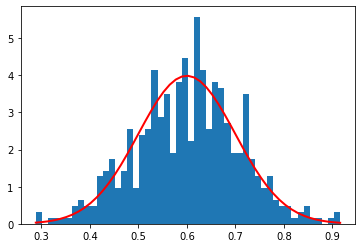

In [20]:
mu = 0.6
sigma = .1
num_reps = 500

mu = 0.6
sigma = .1
num_reps = 500
input_list = np.random.normal(mu,sigma, size = num_reps) #, sigma, num_reps).round(4)

count, bins, ignored = plt.hist(input_list, 50, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
plt.show()

### INPUT TO MODEL LIST: ### CAN BE AUTOMATED FOR USER TO LABEL THE VARIABLE. TOOD ###
no_of_proc = 2
list_final = []
for i in range(no_of_proc):
    part2 = len(input_list) / no_of_proc
    i2 = ((i+1)*part2)
    list1 = input_list[int(i*part2):int(i2)]
    list_final.append(list1)

In [28]:
#def monte_run(value_list):
#    print('goes in')

up_name = "tri_media_filtration" # which unit process it applies to. TODO hould be user input.
cost_range_list = []; #results will be inputted in this array

#for value_change in pct_to_target1: # cycles through each value from MC range
for value_change in list_final[0]:

    # create and build model
    m = wt.watertap_setup(dynamic = False)
    m = wt.case_study_trains.get_case_study(name = 'carlsbad', flow = 4.5833, m = m)

    getattr(m.fs, up_name).water_recovery.fix(value_change)

    # set variable to MC value
    result = wt.run_water_tap(m)
    results_table = get_results_table(m, unit_process_name)
    cost_range_list.append(results_table.total_up_cost.sum())
        
#    return cost_range_list

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

total_up_cost: 23.36602514523
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.coag_floc
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9352560524954, (0.0, 'TOC'): 139.98741089909635, (0.0, 'nitrates'): -3.5805609805422574e-21}
         :    flow_vol : {0.0: 4.583253806033079}
         :    pressure : {0.0: 199999.9998}
         : temperature : {0.0: 300.0}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9666870392067, (0.0, 'TOC'): 76.99643736391516, (0.0, 'nitrates'): -4.111561412718466e-21}
         :    flow_vol : {0.0: 4.583053718734507}
         :    pressure : {0.0: 199999.9997}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1.5795310239482632e-14, (0.0, 'TOC'): 686849.9626745364, (0.0, 'nitrates'): 5.787581854600506e-18}
 

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142737182, (0.0, 'TOC'): 139.9860027754452, (0.0, 'nitrates'): -2.5265998374731667e-21}
         :    flow_vol : {0.0: 4.583299909128787}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1675.9495686768087, (0.0, 'TOC'): 325.87908279826456, (0.0, 'nitrates'): 5.881182555101469e-17}
         :    flow_vol : {0.0: 0.00019690186755472487}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
Show som

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280392999733, (0.0, 'TOC'): 139.98600764166147, (0.0, 'nitrates'): -1.0413662835795577e-20}
         :    flow_vol : {0.0: 4.5832997498033725}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1979.8468855774888, (0.0, 'TOC

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

total_up_cost: 15.121692104038862
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.mixer1
inlet1 : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9485237239586, (0.0, 'TOC'): 76.99449489825669, (0.0, 'nitrates'): 4.230837357489942e-21}
         :    flow_vol : {0.0: 4.58316934290311}
         :    pressure : {0.0: 199999.9997}
         : temperature : {0.0: 300.0}
inlet2 : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 0.0001, (0.0, 'TOC'): 0.0001, (0.0, 'nitrates'): 0.0001}
         :    flow_vol : {0.0: 3.3341318472912294}
         :    pressure : {0.0: 199999.99949999998}
         : temperature : {0.0: 300.0}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 416.764028113498, (0.0, 'TOC'): 44.57063505935953, (0.0, 'nitrates'): 4.211197436091716e-05}
         :    flow_vol : {0.0: 7.91730

outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 355.50584410241294, (0.0, 'TOC'): 152.07762829898627, (0.0, 'nitrates'): 0.00014368853338676273}
         :    flow_vol : {0.0: 2.3203882513831724}
         :    pressure : {0.0: 199999.99849999996}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 5.180181416995163e-20, (0.0, 'TOC'): -7.830887631177589e-20, (0.0, 'nitrates'): 6.265612804003662e-25}
         :    flow_vol : {0.0: 2.3204114554697956e-05}
         :    pressure : {0.0: 199999.99849999996}
         : temperature : {0.0: 299.9999}
Show some costing values
---------------------
should have a cost TWS_24_hr
total_up_cost: 12.994485333008486
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.muni
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0,

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142731319, (0.0, 'TOC'): 139.9860027753312, (0.0, 'nitrates'): -3.4890960628181775e-21}
         :    flow_vol : {0.0: 4.583299909132519}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1904.4120836100415, (0.0, 'TOC')

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142733757, (0.0, 'TOC'): 139.9860027753786, (0.0, 'nitrates'): -9.895425036708696e-22}
         :    flow_vol : {0.0: 4.583299909130966}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1676.7525154463026, (0.0, 'TOC'):

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142736868, (0.0, 'TOC'): 139.98600277543912, (0.0, 'nitrates'): -2.491133330303966e-21}
         :    flow_vol : {0.0: 4.583299909128986}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1676.3044313082119, (0.0, 'TOC'): 325.94808386548186, (0.0, 'nitrates'): 5.799854651156278e-17}
         :    flow_vol : {0.0: 0.00019686018472340637}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
Show som

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9357553595551, (0.0, 'TOC'): 139.98750798658017, (0.0, 'nitrates'): 5.560032851428466e-18}
         :    flow_vol : {0.0: 4.583250627345308}
         :    pressure : {0.0: 199999.9998}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): -1.004587431268139e-09, (0.0, 'TOC'): 1.4013255773040634e-09, (0.0, 'nitrates'): -5.573040684316077e-13}
         :    flow_vol : {0.0: 4.583296460242802e-05}
         :    pressure : {0.0: 199999.9998}
         : temperature : {0.0: 300.0}
Show some costing values
---------------------
should have a cost swoi
total_up_cost: 23.366010240598488
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.coag_floc
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.935755359

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

  92  0.0000000e+00 1.62e-02 9.58e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
  93  0.0000000e+00 2.34e+02 1.51e+10  -2.5 5.61e+05    -  1.00e+00 1.00e+00w  1
  94  0.0000000e+00 2.73e+00 2.41e+10  -2.5 1.27e+02   3.9 1.00e+00 1.00e+00w  1
  95  0.0000000e+00 7.98e+03 5.13e+15  -2.5 1.74e+08    -  1.00e+00 1.00e+00w  1
  96  0.0000000e+00 1.62e-02 9.57e+05  -2.5 1.20e+02   3.4 1.00e+00 6.10e-05h 14
  97  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
  98  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
  99  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
 101  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
 102  0.0000000e+00 1.62e-02 9.57e+05  -2.5 5.61e+05    -  1.00e+00 6.10e-05h 15
 103  0.0000000e+00 1.62e-02

 205  0.0000000e+00 1.61e-02 9.53e+05  -2.5 5.63e+05    -  1.00e+00 6.10e-05h 15
 206  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.63e+05    -  1.00e+00 6.10e-05h 15
 207  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.63e+05    -  1.00e+00 6.10e-05h 15
 208  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.64e+05    -  1.00e+00 6.10e-05h 15
 209  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.64e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  0.0000000e+00 2.34e+02 8.17e+09  -2.5 5.64e+05    -  1.00e+00 1.00e+00w  1
 211  0.0000000e+00 3.32e-01 9.31e+08  -2.5 2.51e+01   4.4 1.00e+00 1.00e+00w  1
 212  0.0000000e+00 4.14e+03 1.91e+15  -2.5 9.04e+07    -  1.00e+00 1.00e+00w  1
 213  0.0000000e+00 1.61e-02 9.52e+05  -2.5 1.01e+01   3.9 1.00e+00 6.10e-05h 14
 214  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.64e+05    -  1.00e+00 6.10e-05h 15
 215  0.0000000e+00 1.61e-02 9.52e+05  -2.5 5.64e+05    -  1.00e+00 6.10e-05h 15
 216  0.0000000e+00 1.61e-02

 313  0.0000000e+00 1.60e-02 9.48e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 314  0.0000000e+00 2.34e+02 8.23e+09  -2.5 5.66e+05    -  1.00e+00 1.00e+00w  1
 315  0.0000000e+00 2.63e-01 6.23e+08  -2.5 2.06e+01   4.4 1.00e+00 1.00e+00w  1
 316  0.0000000e+00 2.63e+03 9.56e+14  -2.5 5.73e+07    -  1.00e+00 1.00e+00w  1
 317  0.0000000e+00 1.60e-02 9.48e+05  -2.5 1.15e+01   4.0 1.00e+00 6.10e-05h 14
 318  0.0000000e+00 1.60e-02 9.48e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 319  0.0000000e+00 1.60e-02 9.47e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  0.0000000e+00 1.60e-02 9.47e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 321  0.0000000e+00 1.60e-02 9.47e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 322  0.0000000e+00 1.60e-02 9.47e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 323  0.0000000e+00 1.60e-02 9.47e+05  -2.5 5.66e+05    -  1.00e+00 6.10e-05h 15
 324  0.0000000e+00 1.60e-02

 415  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 416  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 417  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 418  0.0000000e+00 2.34e+02 8.29e+09  -2.5 5.68e+05    -  1.00e+00 1.00e+00w  1
 419  0.0000000e+00 1.31e+00 8.61e+09  -2.5 7.68e+01   4.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  0.0000000e+00 1.79e+03 5.36e+14  -2.5 3.90e+07    -  1.00e+00 1.00e+00w  1
 421  0.0000000e+00 1.59e-02 9.43e+05  -2.5 3.46e+01   3.5 1.00e+00 6.10e-05h 14
 422  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 423  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 424  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 425  0.0000000e+00 1.59e-02 9.43e+05  -2.5 5.68e+05    -  1.00e+00 6.10e-05h 15
 426  0.0000000e+00 1.59e-02

 528  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 529  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 531  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 532  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 533  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 534  0.0000000e+00 1.58e-02 9.38e+05  -2.5 5.70e+05    -  1.00e+00 6.10e-05h 15
 535  0.0000000e+00 2.34e+02 8.37e+09  -2.5 5.70e+05    -  1.00e+00 1.00e+00w  1
 536  0.0000000e+00 2.31e-01 4.98e+08  -2.5 1.85e+01   4.5 1.00e+00 1.00e+00w  1
 537  0.0000000e+00 1.24e+03 3.06e+14  -2.5 2.70e+07    -  1.00e+00 1.00e+00w  1
 538  0.0000000e+00 1.58e-02 9.38e+05  -2.5 1.19e+01   4.0 1.00e+00 6.10e-05h 14
 539  0.0000000e+00 1.58e-02

 627  0.0000000e+00 1.42e+02 2.44e+12  -2.5 1.30e+03   3.7 1.00e+00 1.00e+00w  1
 628  0.0000000e+00 9.18e+02 2.24e+14  -2.5 2.00e+07    -  1.00e+00 1.00e+00w  1
 629  0.0000000e+00 1.58e-02 9.34e+05  -2.5 4.78e+01   4.1 1.00e+00 6.10e-05h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  0.0000000e+00 1.58e-02 9.34e+05  -2.5 5.72e+05    -  1.00e+00 6.10e-05h 15
 631  0.0000000e+00 1.58e-02 9.34e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 632  0.0000000e+00 1.58e-02 9.34e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 633  0.0000000e+00 1.58e-02 9.34e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 634  0.0000000e+00 1.58e-02 9.34e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 635  0.0000000e+00 1.58e-02 9.33e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 636  0.0000000e+00 1.58e-02 9.33e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 637  0.0000000e+00 1.58e-02 9.33e+05  -2.5 5.73e+05    -  1.00e+00 6.10e-05h 15
 638  0.0000000e+00 1.58e-02

 748  0.0000000e+00 1.57e-02 9.29e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 749  0.0000000e+00 1.57e-02 9.29e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 751  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 752  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 753  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 754  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 755  0.0000000e+00 1.57e-02 9.28e+05  -2.5 5.75e+05    -  1.00e+00 6.10e-05h 15
 756  0.0000000e+00 2.33e+02 8.51e+09  -2.5 5.75e+05    -  1.00e+00 1.00e+00w  1
 757  0.0000000e+00 5.21e+01 8.40e+11  -2.5 7.64e+02   3.7 1.00e+00 1.00e+00w  1
 758  0.0000000e+00 6.67e+02 1.36e+14  -2.5 1.45e+07    -  1.00e+00 1.00e+00w  1
 759  0.0000000e+00 1.57e-02

 846  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 847  0.0000000e+00 2.33e+02 8.56e+09  -2.5 5.77e+05    -  1.00e+00 1.00e+00w  1
 848  0.0000000e+00 4.62e-01 1.69e+09  -2.5 3.43e+01   4.2 1.00e+00 1.00e+00w  1
 849  0.0000000e+00 5.60e+02 9.23e+13  -2.5 1.22e+07    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850  0.0000000e+00 1.56e-02 9.24e+05  -2.5 6.05e+00   3.8 1.00e+00 6.10e-05h 14
 851  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 852  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 853  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 854  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 855  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 856  0.0000000e+00 1.56e-02 9.24e+05  -2.5 5.77e+05    -  1.00e+00 6.10e-05h 15
 857  0.0000000e+00 1.56e-02

 963  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 964  0.0000000e+00 2.33e+02 8.64e+09  -2.5 5.80e+05    -  1.00e+00 1.00e+00w  1
 965  0.0000000e+00 7.62e+00 9.37e+10  -2.5 2.56e+02   3.8 1.00e+00 1.00e+00w  1
 966  0.0000000e+00 4.28e+02 6.61e+13  -2.5 9.33e+06    -  1.00e+00 1.00e+00w  1
 967  0.0000000e+00 1.55e-02 9.19e+05  -2.5 7.28e+04   3.3 1.00e+00 6.10e-05h 14
 968  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 969  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 971  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 972  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 973  0.0000000e+00 1.55e-02 9.19e+05  -2.5 5.80e+05    -  1.00e+00 6.10e-05h 15
 974  0.0000000e+00 1.55e-02

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9396675802258, (0.0, 'TOC'): 139.98826869615502, (0.0, 'nitrates'): -1.0796962546883942e-21}
         :    flow_vol : {0.0: 4.583225721525209}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 2408.585187680714, (0.0, 'TOC')

should have a cost ammonia
total_up_cost: 0.8416593485221344
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.TWS_24_hr
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 371.47522494096216, (0.0, 'TOC'): 158.9091251386062, (0.0, 'nitrates'): 0.00031231412162120205}
         :    flow_vol : {0.0: 2.2206371208609808}
         :    pressure : {0.0: 199999.9986}
         : temperature : {0.0: 299.9999}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 371.47893973035946, (0.0, 'TOC'): 158.91071424574864, (0.0, 'nitrates'): 0.0003123172447936499}
         :    flow_vol : {0.0: 2.220614914489772}
         :    pressure : {0.0: 199999.9985}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1.499156945402226e-17, (0.0, 'TOC'): 6.3409916467177506e-18, (

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

total_up_cost: 12.991578341581974
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.muni
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 355.6321649507247, (0.0, 'TOC'): 152.13166677018498, (0.0, 'nitrates'): 0.00014505398121971818}
         :    flow_vol : {0.0: 2.31956404964044}
         :    pressure : {0.0: 199999.9985}
         : temperature : {0.0: 299.9999}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 355.6357213079378, (0.0, 'TOC'): 152.133188102066, (0.0, 'nitrates'): 0.0001450554317740359}
         :    flow_vol : {0.0: 2.3195408539999436}
         :    pressure : {0.0: 199999.99839999998}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 0.0, (0.0, 'TOC'): 0.0, (0.0, 'nitrates'): -2.61012178719941e-54}
         :    flow_vol : 

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.928014273507, (0.0, 'TOC'): 139.98600277540413, (0.0, 'nitrates'): -1.7458127752813195e-21}
         :    flow_vol : {0.0: 4.5832999091301305}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1676.3916695773719, (0.0, 'TOC'

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

total_up_cost: 0.863671136772429
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.TWS_24_hr
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 350.4124328454973, (0.0, 'TOC'): 149.89873207323757, (0.0, 'nitrates'): 8.985431655149867e-05}
         :    flow_vol : {0.0: 2.3541161105022472}
         :    pressure : {0.0: 199999.99859999996}
         : temperature : {0.0: 299.9999}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 350.41593700486726, (0.0, 'TOC'): 149.90023107554828, (0.0, 'nitrates'): 8.985521510364971e-05}
         :    flow_vol : {0.0: 2.3540925693411427}
         :    pressure : {0.0: 199999.99849999996}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 6.282094836557323e-16, (0.0, 'TOC'): 2.235622209652225e-16, (0.0, 'nitrates'

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.928014273129, (0.0, 'TOC'): 139.98600277533063, (0.0, 'nitrates'): -3.485856725031128e-21}
         :    flow_vol : {0.0: 4.5832999091325375}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1904.4682055970131, (0.0, 'TOC')

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

total_up_cost: 0.951906619207032
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.SBA
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 737.7281261171547, (0.0, 'TOC'): 78.89596652343754, (0.0, 'nitrates'): 4.6945340756506046e-05}
         :    flow_vol : {0.0: 4.472713043678965}
         :    pressure : {0.0: 199999.99929999997}
         : temperature : {0.0: 299.9999}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 737.7355034721894, (0.0, 'TOC'): 78.89675549099243, (0.0, 'nitrates'): 4.6945810214608185e-05}
         :    flow_vol : {0.0: 4.472668316548528}
         :    pressure : {0.0: 199999.99919999996}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): -4.539744027457148e-16, (0.0, 'TOC'): -4.856251588606477e-16, (0.0, 'nitrates'): -7.6

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9279999997722, (0.0, 'TOC'): 139.98599999995568, (0.0, 'nitrates'): -5.594429512555945e-16}
         :    flow_vol : {0.0: 4.583300000001451}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): -113758914466.37604, (0.0, 'TOC'

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142732183, (0.0, 'TOC'): 139.98600277534803, (0.0, 'nitrates'): -3.513150180933544e-21}
         :    flow_vol : {0.0: 4.583299909131968}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1902.4506291069292, (0.0, 'TOC')

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.928219312264, (0.0, 'TOC'): 139.98604264405134, (0.0, 'nitrates'): -1.0037286920670584e-19}
         :    flow_vol : {0.0: 4.583298603785944}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 969.6103396845217, (0.0, 'TOC'): 188.53534382748856, (0.0, 'nitrates'): 1.3517001310229546e-15}
         :    flow_vol : {0.0: 0.0003403404300611583}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
Show some

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280393128793, (0.0, 'TOC'): 139.986007644171, (0.0, 'nitrates'): -1.124556078761797e-20}
         :    flow_vol : {0.0: 4.583299749721209}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1438.6397870091716, (0.0, 'TOC'): 

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

Show some costing values
---------------------
should have a cost cf
total_up_cost: 13.289249352155373
----------------------------------------------------------------------
----------------------------------------------------------------------
fs.ro
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 732.0224982205663, (0.0, 'TOC'): 78.28576783585065, (0.0, 'nitrates'): 3.184887849472834e-05}
         :    flow_vol : {0.0: 4.507574772608946}
         :    pressure : {0.0: 199999.99909999996}
         : temperature : {0.0: 299.9999}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 347.6084488756878, (0.0, 'TOC'): 148.69922382228617, (0.0, 'nitrates'): 6.049507647043373e-05}
         :    flow_vol : {0.0: 2.3731055420500033}
         :    pressure : {0.0: 199999.99899999995}
         : temperature : {0.0: 299.9999}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1159.41451581518

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

degrees_of_freedom: 0
----------------------------------------------------------------------
fs.source1
inlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 720.0, (0.0, 'TOC'): 140.0, (0.0, 'nitrates'): 0.0}
         :    flow_vol : {0.0: 4.5833}
         :    pressure : {0.0: 200000.0}
         : temperature : {0.0: 300}
outlet : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 719.9280142734142, (0.0, 'TOC'): 139.98600277538608, (0.0, 'nitrates'): -1.3402480213085762e-21}
         :    flow_vol : {0.0: 4.583299909130721}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
waste : Size=1
    Key  : Name        : Value
    None :   conc_mass : {(0.0, 'TDS'): 1676.6384844908748, (0.0, 'TOC'): 326.0130386509997, (0.0, 'nitrates'): 3.120986503469291e-17}
         :    flow_vol : {0.0: 0.0001968209623317848}
         :    pressure : {0.0: 199999.9999}
         : temperature : {0.0: 300.0}
Show some

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/ml_regression.py:149: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)
/Users/amiara/NAWI/WaterTap/

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      755
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      133

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Tot

 206r 0.0000000e+00 4.58e+00 9.89e+01  -5.0 7.23e-01    -  5.89e-01 5.89e-01s 22
 207r 0.0000000e+00 4.58e+00 7.53e+01  -5.0 3.02e-01    -  2.39e-01 2.39e-01s 22
 208r 0.0000000e+00 4.58e+00 5.20e+00  -5.0 7.22e-07   6.9 1.00e+00 1.00e+00s 22
 209r 0.0000000e+00 4.58e+00 2.32e+00  -5.0 2.29e-01    -  5.55e-01 5.55e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 0.0000000e+00 4.58e+00 2.32e+00  -5.0 1.53e+00    -  0.00e+00 0.00e+00R  1
 211r 0.0000000e+00 4.58e+00 2.53e+01  -5.0 9.76e-02    -  1.00e+00 1.00e+00F  1
 212r 0.0000000e+00 4.58e+00 1.79e+01  -5.0 3.88e-02    -  9.79e-01 5.00e-01h  2
 213r 0.0000000e+00 4.58e+00 3.12e+02  -5.0 3.75e-02    -  9.54e-01 2.50e-01h  3
 214r 0.0000000e+00 4.58e+00 4.32e+02  -5.0 3.59e-01    -  1.00e+00 3.12e-02h  6
 215r 0.0000000e+00 4.58e+00 1.12e+02  -5.0 2.15e-01    -  7.94e-01 7.81e-03h  8
 216r 0.0000000e+00 4.58e+00 9.60e+01  -5.0 6.62e-02    -  1.40e-01 1.40e-01s 20
 217r 0.0000000e+00 4.58e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 0.0000000e+00 4.58e+00 7.17e+06  -7.5 8.86e+04    -  8.03e-04 6.04e-04f  1
 391r 0.0000000e+00 4.58e+00 7.17e+06  -7.5 9.31e-05   8.2 2.81e-05 1.32e-04h  1
 392r 0.0000000e+00 4.58e+00 7.16e+06  -7.5 5.23e-05   7.7 3.90e-02 1.71e-03f  7
 393r 0.0000000e+00 4.58e+00 7.16e+06  -7.5 6.51e+05    -  0.00e+00 2.53e-16R 24
 394r 0.0000000e+00 4.58e+00 7.12e+06  -7.5 7.21e-05   7.2 1.00e+00 5.39e-03f  1
 395r 0.0000000e+00 4.58e+00 7.11e+06  -7.5 1.59e+06    -  3.27e-02 1.03e-03f  5
 396r 0.0000000e+00 4.58e+00 7.11e+06  -7.5 1.71e-04   6.8 3.36e-02 1.18e-09h 13
 397r 0.0000000e+00 4.58e+00 7.11e+06  -7.5 5.67e+06    -  4.64e-02 1.97e-05f  4
 398r 0.0000000e+00 4.58e+00 6.90e+06  -7.5 6.79e-05   7.2 1.00e+00 2.94e-02f  3
 399r 0.0000000e+00 4.58e+00 6.61e+06  -7.5 2.09e-04   6.7 3.56e-01 4.29e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r 0.0000000e+00 4.58e+00

ValueError: Cannot load a SolverResults object with bad status: error

In [35]:
####TO DO LOAD AND SAVE!!

In [36]:
#### SAVE TRAIN ####
# path = 'trains/Tutorial1_treatment_train_example.csv'
# wt.save_train(T, path)

In [37]:
# #### LOAD TRAIN ####
# path = 'trains/Tutorial1_treatment_train_example.csv'
# TT = wt.load_train(path)

In [38]:
# wt.display.show_train(TT)